In [10]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import re
import nltk
from kneed import KneeLocator
import matplotlib.pyplot as plt

nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

sw = set(stopwords.words('english'))
ps = PorterStemmer()

# Load CSV file
df = pd.read_csv('./csv/ocr/dankmemes-top-ocr.csv')

def clean(t):
    text = str(t).lower()
    text = re.sub(r"\[(.*?)\]", "", text)
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"\w+…|…", "", text)
    text = re.sub(r"(?<=\w)-(?=\w)", " ", text)

    text = re.sub(r"made with me matic", " ", text)
    text = re.sub(r"me matic", " ", text)
    text = re.sub(r"img flip com", " ", text)
    text = re.sub(r"img i ipcom", " ", text)
    text = re.sub(r"flip com", " ", text)
    text = re.sub(r"img lip com", " ", text)
    text = re.sub(r"img lip", " ", text)
    text = re.sub(r"lip com", " ", text)
    text = re.sub(r"tenor", " ", text)
    text = re.sub(r"reddito rs", "redditors", text)

    tokens = text.split()
    tokens = [t for t in tokens if not t in sw]
    tokens = ["" if t.isdigit() else t for t in tokens]
    tokens = [t for t in tokens if len(t) > 1]
    # tokens = [ps.stem(token) for token in tokens]
    return " ".join(tokens)

# Combine 'text' and 'caption' columns
df['combined_text'] = df['text'].fillna('') + ' ' + df['caption'].fillna('')
df['combined_text'] = df['combined_text'].apply(clean)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chayapatr/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Create a TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the combined text
X = vectorizer.fit_transform(df['combined_text'])

# Perform KMeans clustering
num_clusters = 5  # You can adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Initialize a list to store inertia values for different k
inertia_values = []

# Define a range of cluster numbers to try
k_values = range(1, 30)

# Loop through different k values and calculate inertia
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


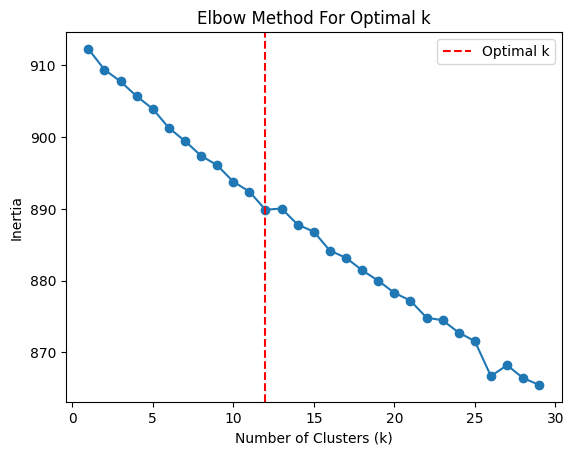

/Users/chayapatr/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
# Use KneeLocator to automatically find the "elbow" point
knee_locator = KneeLocator(k_values, inertia_values, curve="convex", direction="decreasing")
optimal_k = knee_locator.knee

# Plot the elbow curve with the automatic selection
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.axvline(x=optimal_k, color='r', linestyle='--', label='Optimal k')
plt.legend()
plt.show()

# Perform KMeans clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

In [15]:
representatives = []
for i in range(optimal_k):
    cluster_samples = df[df['cluster'] == i]['combined_text']
    representative_idx = pairwise_distances_argmin_min(kmeans.cluster_centers_[i].reshape(1, -1), X[cluster_samples.index])[0][0]
    representatives.append(cluster_samples.iloc[representative_idx])

# Print representatives for each cluster
for i, rep in enumerate(representatives):
    print(f"Cluster {i + 1} Representative:")
    print(rep)
    print("-----------------------")

# Optionally, you can save the cluster assignments to a new CSV file
df[['post_name', 'combined_text', 'cluster']].to_csv('clustered_data.csv', index=False)

Cluster 1 Representative:
gh rls pratt prime video rosa parks int finna move something something russian war machine
-----------------------
Cluster 2 Representative:
girls think react make cringes wa faces actually react don’t fool me.
-----------------------
Cluster 3 Representative:
dad showing old wwf videos see mom part hoe train wait hol
-----------------------
Cluster 4 Representative:
watching akidbuilda5 star hotel fort nite getting shot i'm builds guy
-----------------------
Cluster 5 Representative:
iefiergetting0spanishado youtube like funny words magic man con even saying????
-----------------------
Cluster 6 Representative:
people dont know people know chandler dank
-----------------------
Cluster 7 Representative:
everyday men day men dont need day mens day insult womens struggle boys way celebrate mens day anyway happy international men's day bros
-----------------------
Cluster 8 Representative:
anyone get this?
-----------------------
Cluster 9 Representative:
stops u

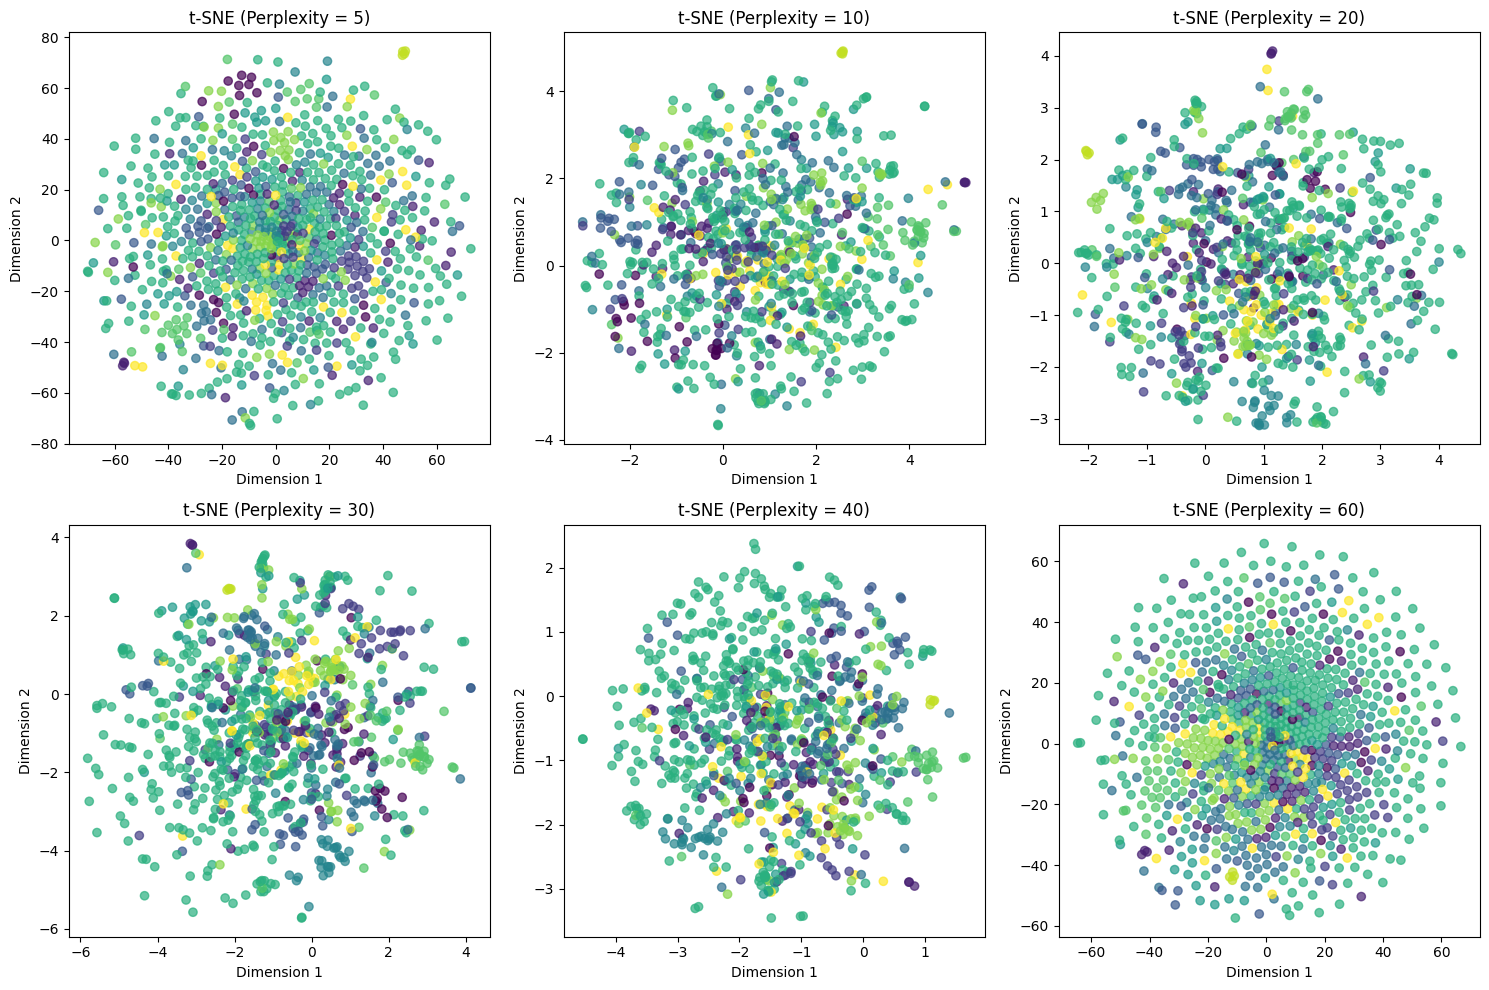

In [32]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Experiment with different perplexity values
perplexities = [5, 10, 20, 30, 40, 60]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, perplexity in enumerate(perplexities):
    # Apply t-SNE to visualize in 2D space
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X.toarray())

    # Create a scatter plot with different colors for each cluster
    ax = axes[i // 3, i % 3]
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7)
    ax.set_title(f't-SNE (Perplexity = {perplexity})')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

plt.tight_layout()
plt.show()

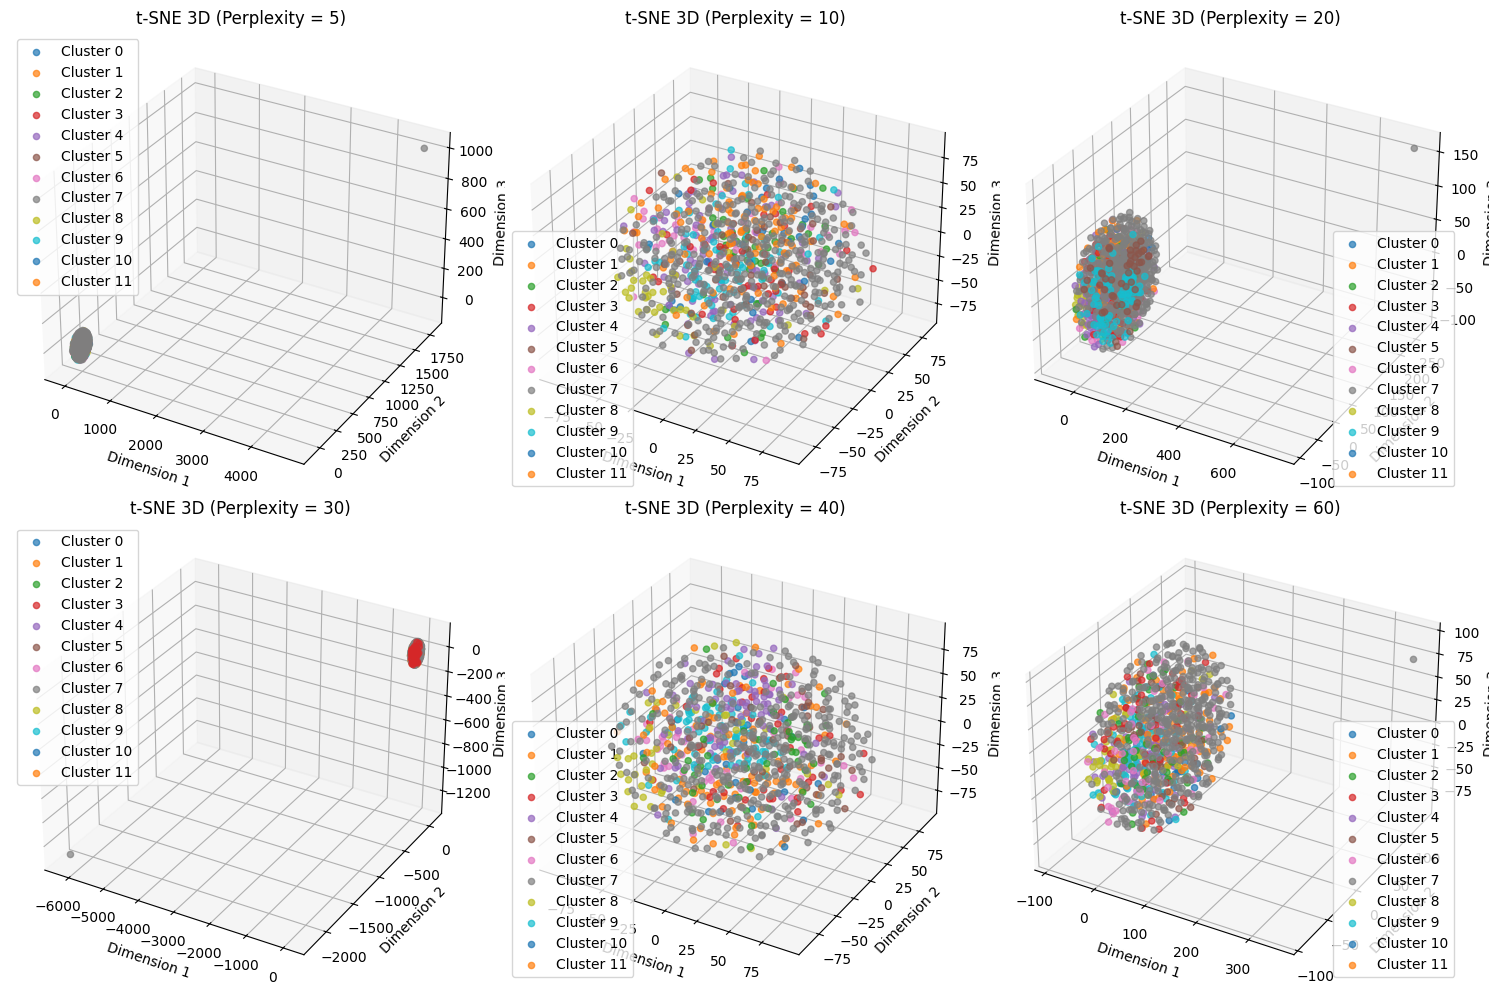

In [34]:
# Apply t-SNE to visualize in 3D space
perplexities = [5, 10, 20, 30, 40, 60]
fig = plt.figure(figsize=(15, 10))

for i, perplexity in enumerate(perplexities):
    # Apply t-SNE to visualize in 3D space
    tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X.toarray())

    # Create a 3D scatter plot with different colors for each cluster
    ax = fig.add_subplot(2, 3, i + 1, projection='3d')
    for cluster_id in range(optimal_k):
        cluster_mask = df['cluster'] == cluster_id
        ax.scatter(X_tsne[cluster_mask, 0], X_tsne[cluster_mask, 1], X_tsne[cluster_mask, 2], label=f'Cluster {cluster_id}', alpha=0.7)

    ax.set_title(f't-SNE 3D (Perplexity = {perplexity})')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_zlabel('Dimension 3')
    ax.legend()

plt.tight_layout()
plt.show()

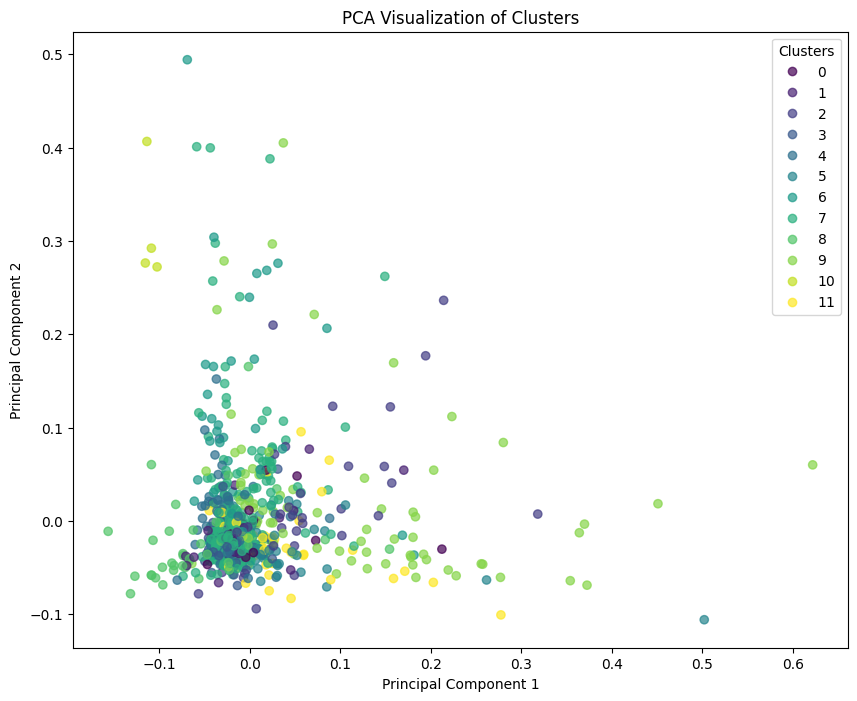

In [35]:
from sklearn.decomposition import PCA
# Apply PCA to visualize in 2D space
pca = PCA(n_components=2, random_state=3)
X_pca = pca.fit_transform(X.toarray())

# Create a scatter plot with different colors for each cluster
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.title('PCA Visualization of Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title='Clusters')
plt.show()